In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
import pickle
# CUSTOM
import mbr_kernel as mkn
from outils_classification_810 import feature_importance_XGBoost
from outils_feature_engineering_810 import get_qcut_of_columns

TEST_SIZE = 0.2
RANDOM_STATE = 42
DASHBOARD_DATA = './st_content/'

# 0. Recuperation des fichiers lies au model

Recuperer le nom du model de reference depuis l'UI MLFLOW :

In [2]:
model_filename = './mlruns/0/86ac7fc843804367a1ff5e938a0c2149/artifacts/XGBoost/model.pkl'

# TODO : Copy file to API REPO

# 1. Identification des features les plus importantes

Forme initiale du Dataframe :  (307511, 122)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
/home/maximorose/git_repositories/cln_oc_p07/mbr_kernel.py:186: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

Forme du Dataframe apres traitement :  (219656, 122)

Application dataframe shape:  (219656, 14)
application processing - done in 1s
Forme initiale du Dataframe :  (1716428, 17)
Forme du Dataframe apres traitement :  (1716428, 17)
Bureau dataframe shape:  (305811, 8)
Bureau and bureau_balance processing - done in 8s
Forme initiale du Dataframe :  (1670214, 37)


/home/maximorose/git_repositories/cln_oc_p07/outils_feature_engineering_810.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df.drop(columns=['taux_nan'], inplace=True)


Forme du Dataframe apres traitement :  (1234578, 37)
Forme initiale du Dataframe :  (13605401, 8)
Forme du Dataframe apres traitement :  (13605401, 8)
Previous Application dataframe shape:  (338308, 12)
Previous application processing - done in 27s
Pos-Cash dataframe shape:  (337252, 3)
Pos-Cash processing - done in 5s
Installement dataframe shape:  (339587, 7)
Installment processing - done in 15s
CC dataframe shape:  (103558, 6)
CC processing - done in 6s
X_train : (175724, 48) // X_test : (43932, 48)
y_train : (175724,) // y_test : (43932,)
Testing model...
AUC :  0.6943685696075753


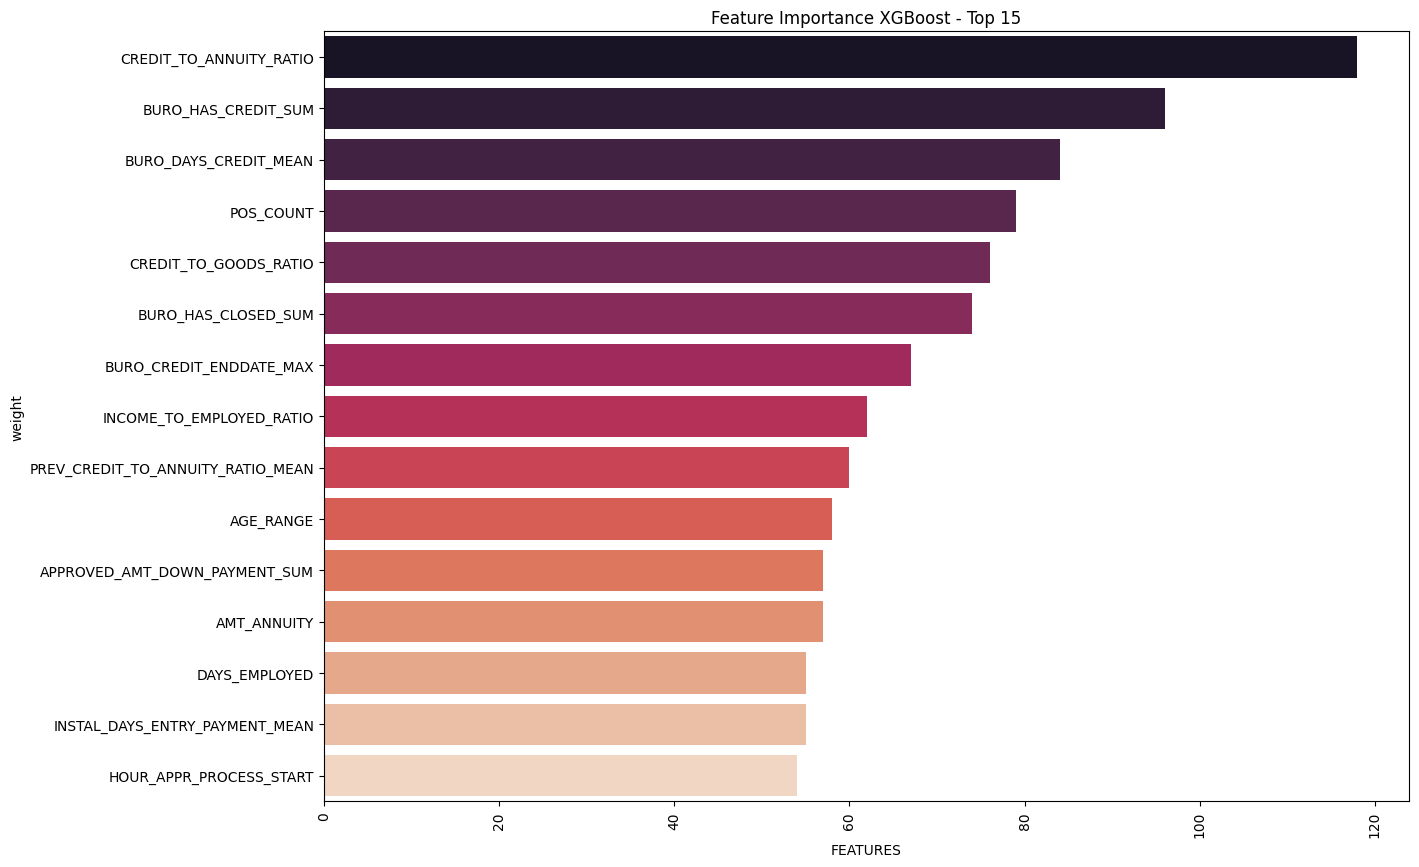

In [3]:
df_train = pd.read_csv('./input_data/application_train.csv')
df = mkn.full_feature_engineering(df_input=df_train, df_folder='./input_data/',encoding_treshold=0.04, nan_treshold=0.4)
X = df.drop(columns = ['SK_ID_CURR', 'TARGET'])
y = df['TARGET']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"X_train : {X_train.shape} // X_test : {X_test.shape}")
print(f"y_train : {y_train.shape} // y_test : {y_test.shape}")

loaded_model = pickle.load(open(model_filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print("Testing model...")
print("AUC : ", result)

xgb_estim = loaded_model['estimator']
feat_imps = feature_importance_XGBoost(xgb_estimator=xgb_estim, feature_names=X_train.columns, importance_type='weight')

## Sauvegarde Top 10 features XGBoost

In [15]:
TOP_N = 7
TOP_FEATS_FILE = './api_necessary_content/top_10_features.txt'
items = feat_imps.iloc[:TOP_N, 2].tolist()
with open(TOP_FEATS_FILE ,'w') as tfile:
	tfile.write('\n'.join(items))

# 3. Sauvegarde des QCUTS pour ces dix features par rapport au Train Set

In [16]:
# Open the file in read mode
with open(TOP_FEATS_FILE, 'r') as file:
    # Read all the lines of the file into a list
    TOP_FEATS = file.readlines()
TOP_FEATS = [col.replace('\n', '') for col in TOP_FEATS]

In [17]:
print(TOP_FEATS)

['CREDIT_TO_ANNUITY_RATIO', 'BURO_HAS_CREDIT_SUM', 'BURO_DAYS_CREDIT_MEAN', 'POS_COUNT', 'CREDIT_TO_GOODS_RATIO', 'BURO_HAS_CLOSED_SUM', 'BURO_CREDIT_ENDDATE_MAX']


In [18]:
def transform_X(X, loaded_model):
    """Applique les transformation qui precede l'estimator dans le Pipeline. Permet d'obtenir une version des donnees telle que l'estimator traitera"""
    imputer = loaded_model['imputer']
    scaler = loaded_model['scaler']
    X_imp = imputer.transform(X)
    X_sc = scaler.transform(X_imp)
    new_X=pd.DataFrame(X_sc, columns=X.columns.tolist())
    return  new_X

In [19]:
Xt_noId = transform_X(X, loaded_model=loaded_model)

In [20]:
dictres = {}
cnt=0
for feat in TOP_FEATS :
    training_qcut_status = get_qcut_of_columns(idf=Xt_noId, colonne=feat)
    training_qcut_status.to_csv(DASHBOARD_DATA+'top_features_profiles/'+f'{feat}.csv')
    cnt+=1

### Test de l'ouverture de fichier pour estimation d'un candidat

In [10]:
# mon_obs = Xt_noId.iloc[0, :]
# mon_obs

In [11]:
# from outils_feature_engineering_810 import get_cat_for_obs
#
# feat = 'AGE_RANGE'
# wip_df = pd.read_csv(DASHBOARD_DATA+'top_features_profiles/'+f'{feat}.csv')
#
# cat, e_cat= get_cat_for_obs(obs=mon_obs, colonne=feat, qcuts_df=wip_df)

In [12]:
# import os
#
# def list_files_in_folder(folder_path):
#     files = []
#     for file_name in os.listdir(folder_path):
#         file_path = os.path.join(folder_path, file_name)
#         if os.path.isfile(file_path):
#             files.append(file_name)
#     return files
#
#
#
# def get_radar_values(obs, path_to_qcuts_df) :
#     exceeds_train = False
#     output_dict = {}
#     lst_files = list_files_in_folder(path_to_qcuts_df)
#     for file in lst_files :
#         feat_name = file.split('.')[0]
#         qcut_df = pd.read_csv(path_to_qcuts_df+file)
#         cat, ex_cat = get_cat_for_obs(obs, feat_name, qcut_df)
#         output_dict[feat_name] = cat
#         if ex_cat :
#             exceeds_train=True
#
#     if exceeds_train :
#         output_dict['ExceedsKnownData'] = 1
#     else :
#         output_dict['ExceedsKnownData'] = 0
#     return output_dict


In [14]:
# get_radar_values(mon_obs, DASHBOARD_DATA+'top_features_profiles/')